In [16]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

client = QdrantClient(host="localhost", port=6333)
client

In [17]:
# Let's create our first collection

my_collection = "first_collection"

first_collection = client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
)
print(first_collection)

True


C:\Users\Admin\AppData\Local\Temp\ipykernel_18168\895106094.py:5: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  first_collection = client.recreate_collection(


In [18]:
collection_info = client.get_collection(collection_name=my_collection)
list(collection_info)

[('status', <CollectionStatus.GREEN: 'green'>),
 ('optimizer_status', <OptimizersStatusOneOf.OK: 'ok'>),
 ('vectors_count', None),
 ('indexed_vectors_count', 0),
 ('points_count', 0),
 ('segments_count', 8),
 ('config',
  CollectionConfig(params=CollectionParams(vectors=VectorParams(size=100, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), qu

In [19]:
assert collection_info.status == CollectionStatus.GREEN
assert collection_info.vectors_count == None

# Adding points

In [20]:
import numpy as np

In [21]:
data = np.random.uniform(low=-1.0, high=1.0, size=(1_000, 100))
type(data[0, 0]), data[:2, :20], len(data[0])

(numpy.float64,
 array([[ 0.71244486, -0.50107936,  0.12391711, -0.4517674 , -0.69019078,
          0.79937544,  0.14699948,  0.09496133, -0.65802617,  0.29755816,
          0.74537842,  0.56492299,  0.92635142, -0.84504117, -0.55715399,
         -0.01498292,  0.13322574, -0.27071789, -0.52762162,  0.78240913],
        [-0.42836013,  0.40353968, -0.82514205, -0.43050681,  0.80399298,
          0.74842065, -0.23003923, -0.55834748, -0.45542012, -0.67748674,
         -0.39835459, -0.05760136, -0.82121022, -0.29297294, -0.78482415,
          0.21734489,  0.72562375, -0.52893372,  0.36432622, -0.48219598]]),
 100)

In [22]:
index = list(range(len(data)))
index[-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [23]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist()
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [24]:
client.retrieve(
    collection_name=my_collection,
    ids=[100],
    with_vectors=True # the default is False
)

[Record(id=100, payload={}, vector=[-0.025133813, -0.106980145, 0.14892611, 0.011296607, 0.10271142, 0.094712034, -0.13835452, -0.15864046, -0.02622933, -0.11880851, 0.030190885, 0.028164558, -0.16372004, -0.18040568, 0.17232695, -0.061910424, -0.0012277651, -0.06298824, 0.07028838, -0.022066537, -0.14195219, 0.026955362, 0.10088724, 0.063020594, 0.0826999, -0.020799577, 0.11952137, 0.061504725, -0.063839085, 0.11425105, 0.17082217, -0.15450312, -0.10211645, 0.059065275, 0.047303163, -0.026399296, -0.1591974, -0.07376001, 0.014031549, -0.016406812, 0.14387935, 0.075568765, -0.04003736, -0.14071606, 0.022911012, 0.07171648, -0.09659579, -0.051002927, 0.12590568, 0.08411448, 0.036869075, -0.18063681, -0.14987484, -0.076828726, 0.051165815, 0.07265047, 0.11277705, -0.110590614, -0.15470491, -0.041771907, -0.07485027, -0.172346, -0.034819797, -0.12862542, 0.108487196, -0.0712643, -0.12983328, -0.07600198, 0.091493234, -0.03629605, -0.15963806, 0.05366608, -0.03263417, -0.066000365, -0.1006

In [28]:
# update the collection one point at a time

def create_song():
    return np.random.uniform(low=-1.0, high=1.0, size=100).tolist()

client.upsert(
    collection_name=my_collection,
    points=[
        models.PointStruct(
            id=1000,
            vector=create_song(),
        )
    ]
)

UpdateResult(operation_id=3, status=<UpdateStatus.COMPLETED: 'completed'>)

In [29]:
# We can also delete a point in a straightforward fashion.

# this will show the amount of vectors BEFORE deleting the one we just created
print(client.count(
    collection_name=my_collection, 
    exact=True,
))

client.delete(
    collection_name=my_collection,
    points_selector=models.PointIdsList(
        points=[1000],
    ),
)

print(client.count(
    collection_name=my_collection, 
    exact=True,
))

count=1001
count=1000


# Payloads

In [30]:
from faker import Faker

fake_something = Faker()
fake_something.name()

'Daniel Molina'

In [31]:
payload = []

for i in range(len(data)):
    payload.append(
        {
            "artist":   fake_something.name(),
            "song":     " ".join(fake_something.words()),
            "url_song": fake_something.url(),
            "year":     fake_something.year(),
            "country":  fake_something.country()
        }
    )

payload[:3]

[{'artist': 'Judy Jackson',
  'song': 'home around another',
  'url_song': 'http://www.sanchez.org/',
  'year': '2003',
  'country': 'Algeria'},
 {'artist': 'Allen Ayala III',
  'song': 'back level improve',
  'url_song': 'http://www.vincent.com/',
  'year': '2007',
  'country': 'Guyana'},
 {'artist': 'Kayla Ruiz',
  'song': 'organization not three',
  'url_song': 'https://cantu.biz/',
  'year': '1989',
  'country': 'Costa Rica'}]

In [32]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=index,
        vectors=data.tolist(),
        payloads=payload
    )
)

UpdateResult(operation_id=5, status=<UpdateStatus.COMPLETED: 'completed'>)

In [35]:
resutls = client.retrieve(
    collection_name=my_collection,
    ids=[10, 50, 100, 500],
    with_vectors=False
)

type(resutls), resutls

(list,
 [Record(id=10, payload={'artist': 'Ethan Daniels', 'country': 'Philippines', 'song': 'executive sister dog', 'url_song': 'https://www.robertson-ruiz.biz/', 'year': '2010'}, vector=None, shard_key=None),
  Record(id=50, payload={'artist': 'Douglas Hill', 'country': 'Holy See (Vatican City State)', 'song': 'determine several hit', 'url_song': 'https://hale.com/', 'year': '2005'}, vector=None, shard_key=None),
  Record(id=100, payload={'artist': 'Katie Kennedy', 'country': 'Djibouti', 'song': 'outside main teacher', 'url_song': 'https://henderson-bell.com/', 'year': '2006'}, vector=None, shard_key=None),
  Record(id=500, payload={'artist': 'Travis Herrera', 'country': 'Pakistan', 'song': 'which little many', 'url_song': 'https://bush.info/', 'year': '1986'}, vector=None, shard_key=None)])

# Search

In [39]:
living_la_vida_loca = create_song()

In [43]:
client.search(
    collection_name=my_collection,
    query_vector=living_la_vida_loca,
    limit=3
)

[ScoredPoint(id=330, version=5, score=0.2840498, payload={'artist': 'Tracey Garcia', 'country': 'Serbia', 'song': 'note speech director', 'url_song': 'http://rivera-donaldson.com/', 'year': '1994'}, vector=None, shard_key=None),
 ScoredPoint(id=57, version=5, score=0.27313703, payload={'artist': 'Kenneth Fields', 'country': 'Algeria', 'song': 'south record soldier', 'url_song': 'http://hart.com/', 'year': '1970'}, vector=None, shard_key=None),
 ScoredPoint(id=451, version=5, score=0.27036247, payload={'artist': 'Tony Davis', 'country': 'North Macedonia', 'song': 'others once leave', 'url_song': 'http://costa-cooper.com/', 'year': '1970'}, vector=None, shard_key=None)]

# Text Data

`pip install qdrant-client transformers datasets torch sentence-transformers`

In [45]:
from datasets import load_dataset

dataset = load_dataset("ag_news", split="train")
dataset

Generating test split: 100%|██████████| 7600/7600 [00:00<00:00, 1463509.96 examples/s]


Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

In [47]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}: {random_sample}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1: 91241
NASA scramjet to attempt Mach 10 flight NASA is hoping to break new speed records later today when it will set loose its third X-43A  quot;scramjet #39; #39; over the Pacific Ocean.

Sample 2: 93176
Specter Gets Hatch Support to Chair Panel (AP) AP - Sen. Arlen Specter gained ground Tuesday toward winning the Senate Judiciary Committee chairmanship, which was thrown into doubt after he said judges who oppose abortion rights would face confirmation problems.

Sample 3: 91904
BEA Releases Enhanced Beehive Open-Source Framework LAS VEGASBEA Systems Inc. has made significant progress in the development of the Apache Beehive component model, which is designed to help accelerate the development of Web services and SOA (service-oriented architecture) applications.

Sample 4: 72892
Tech Briefs Shares of Google rose 8.7 percent in the second trading session after the company said third-quarter profit more than doubled. The shares rose \$14.

Sample 5: 101449
Troussier for Marsei

In [52]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}
id2label

{'0': 'World', '1': 'Sports', '2': 'Business', '3': 'Sci/Tech'}

`pip install matplotlib`

<Axes: title={'center': 'Frequency with which each label appears'}, ylabel='label'>

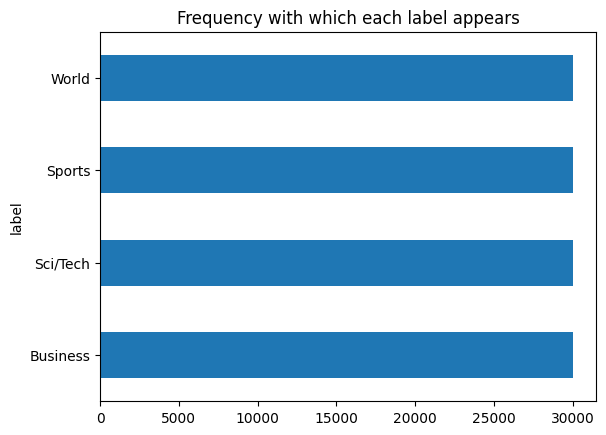

In [55]:
(
    dataset.select_columns('label')
           .to_pandas()
           .astype(str)['label']
           .map(id2label)
           .value_counts()
           .plot(kind="barh", title="Frequency with which each label appears")
)